<a href="https://colab.research.google.com/github/jpiche0720/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train_ = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Begin

In [0]:
import category_encoders as ce
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report


import matplotlib.pyplot as plt

In [0]:
data = train_.copy()

In [0]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Data Cleaning and Feature Engineering

In [0]:
def clean(X):
    X = X.copy()
    
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = ['longitude','latitude','gps_height','population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
   
    # Time Elapsed since construction
    X['construction_year'] = X['construction_year'].replace(0,np.NaN)
    X['construction_year'] = X['construction_year'].replace(np.NaN,round(X['construction_year'].mean()))
    X['elapsed_time'] = (pd.to_datetime(X['date_recorded']).dt.year -
                         pd.to_datetime(X['construction_year'],format='%Y').dt.year)
    
    # Extract dates and remove original columns
    X['date_recorded']= pd.to_datetime(X['date_recorded'])
    X['construction_year'] = pd.to_datetime(X['construction_year'],format='%Y').dt.year
    X['month'] = X['date_recorded'].dt.month
    X['day'] = X['date_recorded'].dt.day
    X['year'] = X['date_recorded'].dt.year               
    
    X = X.drop(columns='date_recorded')  
    
    
    
    # Drop Similar columns and unuseable variance 
    X = X.drop(columns=['payment_type','num_private','extraction_type_group',
                        'extraction_type_class','quantity_group','source_type',
                        'waterpoint_type_group','recorded_by'])
    
        
    high_cardinality = []
    for col in X.columns:
        if X[col].dtype == 'object' and X[col].nunique()>50:
            high_cardinality.append(col)
    
    print('Highly Cardinal Features = ', high_cardinality)
    return X

In [0]:
clean_data = clean(data)

Highly Cardinal Features =  ['funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']


# Model Selection

In [0]:
train, val = train_test_split(clean_data, test_size=0.15,stratify=data['status_group'])
train.shape, val.shape

target = 'status_group'
features = train.columns.drop([target,'id'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

### Random Forest

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(missing_values=np.NaN),
    RandomForestClassifier(random_state=42,n_jobs=-1))


param_dist = {
    'simpleimputer__strategy':['mean','median','most_frequent'],
    'randomforestclassifier__n_estimators':[100,200,300],
    'randomforestclassifier__min_samples_leaf':[3,5,8],
    'randomforestclassifier__max_features':[10,25,36]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

print(search.best_params_)
print(search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 37

{'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_features': 10}
0.8088334323628441


In [0]:
pipeline = search.best_estimator_


train_score = pipeline.score(X_train,y_train)
val_score = pipeline.score(X_val,y_val)
y pred = pipeline.predict(X_val)

print(f'Training accuracy = {train_score}')
print(f'Validation accuracy = {val_score}')

Training accuracy = 0.9313725490196079
Validation accuracy = 0.8120089786756454


# Search Report

In [0]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

,48,38,45,44,35,28,46,18,20,4,...,7,10,13,37,36,34,15,30,40,49
mean_fit_time,54.22,38.8463,63.3814,22.5511,230.081,36.2344,21.2104,35.3812,52.1964,53.3735,...,2.59061,3.04345,2.60355,2.32817,2.56801,2.33875,2.46854,2.49355,2.30893,1.7882
std_fit_time,18.0647,0.963161,3.08193,0.950466,243.118,0.48545,1.90989,0.149568,0.333436,1.5177,...,0.105181,0.155496,0.236396,0.0964209,0.247114,0.0657338,0.0238161,0.0339233,0.127834,0.170897
mean_score_time,0.68737,0.428985,0.732937,0.376365,0.400168,0.424388,0.275985,0.446223,0.62323,0.632035,...,0,0,0,0,0,0,0,0,0,0
std_score_time,0.161379,0.0690934,0.135001,0.148448,0.08961,0.0102833,0.0592227,0.0255501,0.060004,0.0538372,...,0,0,0,0,0,0,0,0,0,0
param_simpleimputer__strategy,mean,median,median,median,most_frequent,mean,most_frequent,mean,mean,median,...,mean,most_frequent,median,most_frequent,mean,mean,median,median,mean,mean
param_randomforestclassifier__n_estimators,300,200,300,100,200,200,100,200,300,300,...,100,300,200,200,200,300,100,100,200,100
param_randomforestclassifier__min_samples_leaf,3,3,3,3,3,3,3,5,5,5,...,3,8,5,5,5,3,8,5,8,8
param_randomforestclassifier__max_features,10,10,10,10,10,10,10,10,10,10,...,36,36,36,36,36,36,36,36,36,36
params,"{'simpleimputer__strategy': 'mean', 'randomfor...","{'simpleimputer__strategy': 'median', 'randomf...","{'simpleimputer__strategy': 'median', 'randomf...","{'simpleimputer__strategy': 'median', 'randomf...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'mean', 'randomfor...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'mean', 'randomfor...","{'simpleimputer__strategy': 'mean', 'randomfor...","{'simpleimputer__strategy': 'median', 'randomf...",...,"{'simpleimputer__strategy': 'mean', 'randomfor...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'median', 'randomf...","{'simpleimputer__strategy': 'most_frequent', '...","{'simpleimputer__strategy': 'mean', 'randomfor...","{'simpleimputer__strategy': 'mean', 'randomfor...","{'simpleimputer__strategy': 'median', 'randomf...","{'simpleimputer__strategy': 'median', 'randomf...","{'simpleimputer__strategy': 'mean', 'randomfor...","{'simpleimputer__strategy': 'mean', 'randomfor..."
split0_test_score,0.810557,0.810755,0.810953,0.810755,0.809368,0.809368,0.808378,0.806793,0.806595,0.805803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Confusion Matrix

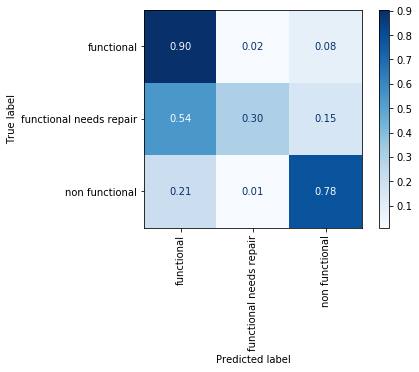

In [0]:
y_pred = pipeline.predict(X_val)
cm = confusion_matrix(y_val,y_pred)

plot_confusion_matrix(pipeline, 
                      X_val, 
                      y_val, 
                      labels=None, 
                      sample_weight=None, 
                      normalize='true', 
                      display_labels=None, 
                      include_values=True, 
                      xticks_rotation='vertical', 
                      values_format='.2f', 
                      cmap='Blues', 
                      ax=None)
plt.show()

In [0]:
print(classification_report(y_val,y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      4839
functional needs repair       0.65      0.30      0.41       647
         non functional       0.84      0.78      0.81      3424

               accuracy                           0.81      8910
              macro avg       0.77      0.66      0.69      8910
           weighted avg       0.81      0.81      0.80      8910



# Feature Importances

In [0]:
clf = pipeline.named_steps['randomforestclassifier']
feats = pd.DataFrame(clf.feature_importances_,features)
feats = feats.reset_index()
feats.columns = ['name','geni']

feats = feats.sort_values(by='geni')

feats = feats.reset_index()
feats = feats.drop(columns='index')
features = feats['name'].to_list()
feats.head()

,name,geni
0,management_group,0.003706
1,year,0.004231
2,quality_group,0.004450
3,water_quality,0.005145
4,permit,0.005681


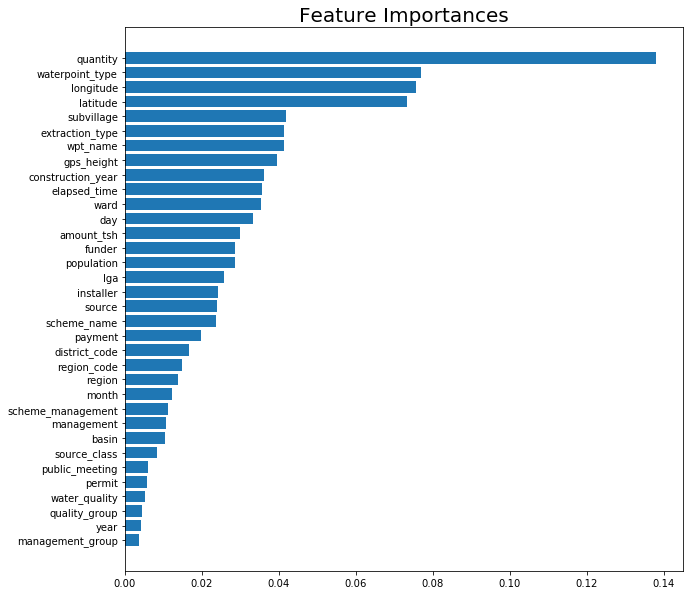

In [0]:
plt.figure(figsize=(10,10))
plt.title('Feature Importances',fontsize=20)
plt.barh(feats['name'],width=feats['geni'])
plt.show()

# Final Submission

In [0]:
features = train.columns.drop([target,'id'])
test = clean(test)
predictions = pipeline.predict(test[features])
print('Prediction.shape',predictions.shape)

col= test['id']
submission = pd.DataFrame(predictions,index=col,columns=['status_group'])

submission = submission.reset_index()
print(submission.shape)
submission.head()

Highly Cardinal Features =  ['funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']
Prediction.shape (14358,)
(14358, 2)


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
def csv_download_link(df, csv_file_name):
    """Display a download link to load a data frame as csv from within a Jupyter notebook"""
    df.to_csv(csv_file_name, index=False)
    from IPython.display import FileLink, FileLinks
    display(FileLink(csv_file_name))
# Diplay download link:
csv_download_link(submission, 'Tanzania.csv')

/Users/jp/DS-Unit-2-Kaggle-Challenge/module4-classification-metrics/Tanzania.csv